### Goal: Utilize Python to construct a quantitative factor, a backtesting engine, and portfolio statistics based on backtesting the quantitative factor

### Install and Import all the required dependencies

In [1]:
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install yfinance
! pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
# import warnings
# warnings.filterwarnings("ignore")
import seaborn as sns
import random
sns.set()
size = 18
params = {'legend.fontsize': 'large',
          'figure.figsize': (15,8),
          'axes.labelsize': size * 0.8,
          'axes.titlesize': size * 0.95,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

## Part 1. Calculation of the Quantitative factor Beta using CAPM Model

The tasks are as follows: <br /> 

a. Calculate beta for each stocks in the entire universe at each Pointdate (irrespective if the stock is in the S&P 500 or not) <br />
b. Use daily returns to calculate beta. Calculate beta based on rolling 252 days of returns. <br />
c. If less than 252 returns for a particular stocks exist, ensure that a minimum of 189 continuous data points of returns exist for the beta calculation. If less than 189 data points exist for a particular stock, set NA for the beta value. <br />
d. Download the S&P 500 returns from yahoo which is to be used as the market return for the beta calculation. <br />
e. The results of this step will be a beta for each stocks at each Pointdate starting near the beginning of 2006 (since it takes 252 days to compute beta and the data starts in 2005). The above calculated beta is the quantitative factor that we will backtest in the next step. <br />


### Read Stocks Returns and download S&P Returns. 

In [3]:
class DataReader:
    
    def __init__(self, path):
        
        #Set Dynamic Path
        self.path = path
        self.df_returns = pd.DataFrame()
        
    def getReturns(self):
        
        self.df_returns = pd.read_csv(self.path)
        self.df_returns['Pointdate'] = pd.to_datetime(self.df_returns['Pointdate'])
        
        self.start_date = min (self.df_returns['Pointdate'])
        self.end_date = max(self.df_returns['Pointdate'])
        n_stocks = len(self.df_returns['ID'].unique())
        print ("Total no. of stocks: ", n_stocks)
        print ("Start date: ", self.start_date)
        print ("End date: ", self.end_date)
        
        return self.df_returns
    
    def pivotReturns(self):
        
        df_pivot_returns = self.df_returns.pivot_table(index=['Pointdate'], columns=['ID'])['Return'].reset_index()
        df_pivot_returns.columns.name = None
        df_pivot_returns = df_pivot_returns.fillna(method = 'bfill')
        df_pivot_returns = df_pivot_returns.fillna(method = 'ffill')
        return df_pivot_returns
    
    def getSNPReturns(self):
        
        snp = yf.download("SPY", start = self.start_date - pd.DateOffset(3), end = self.end_date + pd.DateOffset(1))
        snp_returns = pd.DataFrame()
        snp_returns['Return'] = ((snp['Adj Close'] - snp['Adj Close'].shift(1))/snp['Adj Close'].shift(1))[1:]
        snp_returns = snp_returns.reset_index()
        print ("Successfully fetched S&P 500 Returns")
        return snp_returns


In [4]:
data_reader = DataReader("codeTest.csv")
df_returns = data_reader.getReturns()
df_pivot_returns = data_reader.pivotReturns()
snp_returns = data_reader.getSNPReturns()

Total no. of stocks:  621
Start date:  2005-01-03 00:00:00
End date:  2008-12-31 00:00:00
[*********************100%***********************]  1 of 1 completed
Successfully fetched S&P 500 Returns


### Beta Computation for all Stocks

In [5]:
class Factor:
    
    def ComputeBeta(self, df, snp_returns, treasury_rate = 0.017):

        stocks_id = df['ID'].unique()
        df_beta = pd.DataFrame(columns = ['Pointdate', 'ID', 'Beta', 'IN_Flag'])
        stocks_removed = []

        for stocks in stocks_id:

            #Get stock returns from stock ID
            stock_returns = df.loc[df['ID'] == stocks]
            stock_returns.reset_index(drop=True, inplace=True)

            #Gather market return data for those days where the Stock return exists
            start_date, end_date = min(snp_returns['Date']), max(snp_returns['Date'])
            market_return = snp_returns.loc[(snp_returns['Date'] >= start_date) & (snp_returns['Date'] <= end_date)]
            market_return.reset_index(drop=True, inplace=True)

            #Initialize stock's beta dataframe
            stock_beta = stock_returns
            stock_beta = stock_beta.rename(columns={"Return": "Beta"})

            #Check if no. of days is less than 252
            if len(stock_returns) < 252:

                #Check if no. of days is less than 189
                if len(stock_returns) < 189:

                    #Set Beta for the stock to nan
                    stock_beta['Beta'] = np.nan

                else:
                    #Compute rolling 252 days beta for the stock using rolling covariance between market return and stock return divided by the rolling variance of market return
                    stock_beta['Beta'] = (stock_returns['Return'] - treasury_rate).rolling(252).cov(market_return['Return']-treasury_rate)/(market_return['Return']-treasury_rate).rolling(252).var()

            else:

                #Compute rolling 252 days beta for the stock using rolling covariance between market return and stock return divided by the rolling variance of market return
                stock_beta['Beta'] = (stock_returns['Return']-treasury_rate).rolling(252).cov(market_return['Return']-treasury_rate)/(market_return['Return']-treasury_rate).rolling(252).var()

            stock_beta = stock_beta.dropna()
            df_beta = df_beta.append(stock_beta)
        
        print ("Successfully computed Rolling Beta factor for each stocks")
        return df_beta        
    
    def PivotBeta(self, df_beta):
    
        #Since in our Long Short Portfolio, we are not going to include stocks at a particular pointdate for which IN_Flag = 0, we set the beta for those stocks at those pointdates to nan
        df_beta.loc[df_beta['IN_Flag'] == 0, "Beta"] = np.nan

        #Pivot Beta dataframe on stock ID to get a dataframe with stock ID as columns of the dataframe
        df_pivot_beta = df_beta.pivot_table(index=['Pointdate'], columns=['ID'])['Beta']
        df_pivot_beta.columns.name = None

        #Take cross-section rank according to the beta values of stocks
        df_rank_beta = (df_pivot_beta.rank( axis = 1))

        df_pivot_beta = df_pivot_beta.reset_index()
        df_rank_beta = df_rank_beta.reset_index()

        return (df_pivot_beta, df_rank_beta)

In [6]:
factor = Factor()

In [7]:
df_beta = factor.ComputeBeta(df_returns, snp_returns)
df_pivot_beta, df_rank_beta = factor.PivotBeta(df_beta)

Successfully computed Rolling Beta factor for each stocks


### Visualizing Rolling Betas of few stocks

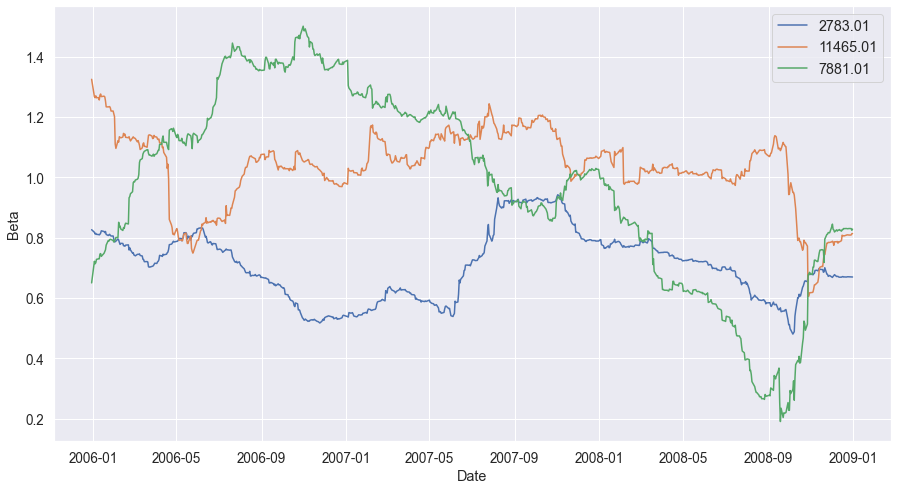

In [8]:
random.seed(7)
stocks_id = random.sample(list(df_returns['ID'].unique()), 3)
for stocks in stocks_id:
    beta_1 = df_beta.loc[df_beta['ID'] == stocks]
    #plt.title("Rolling Beta")
    plt.plot(beta_1['Pointdate'], beta_1['Beta'], label = stocks)
    plt.xlabel("Date")
    plt.ylabel("Beta")
    plt.legend()
plt.show()

## Part 2. Backtest a strategy of longing low beta stocks and shorting high beta stocks

The tasks are as follows: <br /> <br />
a.	We backtest a strategy of longing low beta stocks and shorting high beta stocks. More specifically, at each Pointdate, take a long position in the bottom 10% of stocks based on beta and take a short position in the top 10% of stocks based on beta. <br />
b.	The backtesting should be done only for stocks in the S&P 500 universe, on a monthly basis. So the long basket will hold approximately 50 low beta stocks and the short basket will hold approximately 50 high beta stocks at each Pointdate. Note that the S&P 500 typically has 500 stocks at each Pointdate but occasionally a few more or a few less stocks are introduced. <br />

In [9]:
class PortfolioConstruction:
    
    def __init__(self, df_rank_beta, rebalancing_period = 20, pick_percent = 10, strategy = "equal_weighted"):
        
        #Intialize the portfolio weights dataframe with 0 values
        self.weights = pd.DataFrame(0, index = df_rank_beta['Pointdate'], columns=df_rank_beta.columns[1:]).reset_index()
        self.weights['Pointdate'] = pd.to_datetime(self.weights['Pointdate'])
        
        #Set starting date and max date with pandas index
        self.curr_index = 0
        self.max_index = len(df_rank_beta)
        
        #Set Monthly Portfolio Rebalancing period (Assuming 20 trading days in a month)
        self.rebalancing_period = rebalancing_period
        
        #Intialize other parameters
        self.pick_percent = pick_percent
        self.strategy = strategy
        
    def longShortStrategy(self):
        
        if self.strategy == "equal_weighted":
            self.equalWeightedAllocation()
        
        elif self.strategy == "rank_weighted":
            self.rankWeightedStrategy()
            
        return self.weights
    
    def equalWeightedAllocation(self):
        
        while self.curr_index <= self.max_index:
            
            #Select top 10% and bottom 10% of the total stocks on SNP 500 based on rank of beta.
            total_stocks = np.max(df_rank_beta.iloc[self.curr_index, 1:])
            pick_stocks = int(round(total_stocks * (self.pick_percent / 100), 0))
            conditions = [df_rank_beta.iloc[self.curr_index, 1:] >= total_stocks - pick_stocks, df_rank_beta.iloc[self.curr_index, 1:] <= pick_stocks]
            
            #Assign equal weights to bottom 10% of stocks and top 10% of stocks (Dollar Neutral)
            weights = 1 / (2 * pick_stocks)
            long_short_weights = [-weights, weights]
            self.weights.iloc[self.curr_index: self.curr_index + self.rebalancing_period, 1:] = np.select(conditions, long_short_weights, default = 0)
            
            #Update current index according to the rebalancing period
            self.curr_index += self.rebalancing_period 
    
    
    def rankWeightedAllocation(self):
        
        pass

In [10]:
portfolio_obj = PortfolioConstruction(df_rank_beta, rebalancing_period = 20, pick_percent = 10, strategy = "equal_weighted")
df_weights = portfolio_obj.longShortStrategy()
df_weights

,Pointdate,1013.01,1075.01,1078.01,1161.01,1177.01,1209.01,1239.01,1240.01,1279.01,...,174130.01,174490.01,174729.01,175263.01,176282.01,177264.02,177267.02,177376.02,178310.01,260774.01
0,2005-12-30,-0.01,0.0,0.01,-0.01,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
1,2006-01-03,-0.01,0.0,0.01,-0.01,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
2,2006-01-04,-0.01,0.0,0.01,-0.01,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
3,2006-01-05,-0.01,0.0,0.01,-0.01,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
4,2006-01-06,-0.01,0.0,0.01,-0.01,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2008-12-24,0.00,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.01,-0.01
752,2008-12-26,0.00,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.01,-0.01
753,2008-12-29,0.00,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.01,-0.01
754,2008-12-30,0.00,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.01,-0.01


## Part 3. Compute Portfolio Statistics

The tasks are as follows: <br />
    <br />
    a.	For the backtested portfolio, calculate a number of statistics.<br />
    b.	Time series number of stocks in the long/short portfolio. This should typically be 100 stocks at each Pointdate <br />
    c.	Time series of cumulative wealth curve of the long/short portfolio. Start the wealth curve at $100. <br />
    d.	Time series of the long/short portfolio turnover. The maximum turnover is 400%. Turnover is based on the number of stocks that enter and leave the long portfolio as well as the number of stocks that enter and leave the short portfolio. <br />
    e.	The overall long/short portfolio annualized return, annualized volatility, and Sharpe ratio. <br />
    f.	Provide graphical charts of the above calculated metrics with appropriate axis titles. But if you are unfamiliar with charting in Python, then ignore this step. <br />

In [11]:
class PortfolioStatistics:
    
    def __init__(self, portfolio_weights, stock_daily_returns):
        
        #Start with 100$
        self.starting_wealth = 100
        
        self.portfolio_weights = portfolio_weights
        self.stock_daily_returns = stock_daily_returns
        self.total_days = len(self.portfolio_weights)
        
        #Remove those stocks from daily returns which are absent in the portfolio
        cols_remove = set(self.stock_daily_returns.columns) - set(self.portfolio_weights.columns)
        self.stock_daily_returns.drop(columns=cols_remove, inplace=True)
        
        #Set Stock returns starting date to match with Portfolio weights starting date
        self.stock_daily_returns = self.stock_daily_returns.loc[self.stock_daily_returns['Pointdate'] >= min(self.portfolio_weights['Pointdate'])]
        self.stock_daily_returns.reset_index(drop=True, inplace=True)
        
    
    def portfolioReturns(self):
        
        #Create a Portfolio Statistics dataframe
        self.portfolio_returns = pd.DataFrame(0, index = self.portfolio_weights['Pointdate'], columns=['Daily_Returns', 'Cumulative_Returns']).reset_index()
        self.portfolio_returns['Pointdate'] = pd.to_datetime(self.portfolio_returns['Pointdate'])
        
        #Compute daily and cumulative Returns of the Portfolio
        self.portfolio_returns['Daily_Returns'] = np.multiply(self.stock_daily_returns.iloc[:, 1:], self.portfolio_weights.iloc[:,1:]).sum(axis = 1)
        self.portfolio_returns['Cumulative_Returns'] = self.starting_wealth * np.cumprod(1 + self.portfolio_returns['Daily_Returns'])
        
        return self.portfolio_returns
    
    def numberOfStocks(self):
        
        self.num_stocks = pd.DataFrame(0, index = self.portfolio_weights['Pointdate'], columns=['Total_Stocks']).reset_index()
        self.num_stocks['Pointdate'] = pd.to_datetime(self.num_stocks['Pointdate'])

        self.num_stocks['Total_Stocks'] = self.portfolio_weights.iloc[:,1:].astype(bool).sum(axis=1)
        return self.num_stocks
    
    def annualizedReturns(self):
        
        # Here we assume 252 trading days
        return round((np.prod(1 + self.portfolio_returns['Daily_Returns']) ** (252/self.total_days) - 1) * 100, 3)
    
    def annualizedVolatility(self, days = 252):
        
        return round(self.portfolio_returns['Daily_Returns'].std() * np.sqrt(days), 3)
     
    def annualizedSharpe(self, treasury_rate = 0.017, days=252):
        
        volatility = self.portfolio_returns['Daily_Returns'].std()* np.sqrt(days)
        sharpe = ((self.portfolio_returns['Daily_Returns'].mean() - treasury_rate) / volatility) 
        return round(sharpe, 3)
    
    def turnover(self):
        
        daily_turnover = abs(self.portfolio_weights.iloc[1:, 1:] - self.portfolio_weights.shift(1).iloc[1:, 1:]).sum(axis = 1) * 100
        total_turnover = round((sum(daily_turnover)/(len(daily_turnover) - 1)), 3)
        
        return daily_turnover, total_turnover
    
    def maxDrawdown(self, cumulative_returns):
        
        try:
            
            i = np.argmax((np.maximum.accumulate(cumulative_returns) - cumulative_returns)/cumulative_returns) # end of the period
            j = np.argmax(cumulative_returns[:i]) # start of period

            max_drawdown = ((cumulative_returns[i] - cumulative_returns[j])/cumulative_returns[j])
        
        except Exception as e:
            max_drawdown = 0.01
        
        return round(abs(max_drawdown * 100), 3)
    
    def printPortfolioStatistics(self, annualized_returns, annualized_volatility, sharpe, total_turnover, max_drawdowns, snp_max_drawdowns):
        
        print ("The Performance Statistics of the Portfolio are as follows:\n")
        print ("Annualized Returns: " + str(annualized_returns) + "%")
        print ("Annualized Volatility: ", annualized_volatility)
        print ("Sharpe: ", sharpe)
        print ("Total Turnover: " + str(total_turnover) + "%")
        print ("Maximum Drawdowns: " + str(max_drawdowns) + "%")
        print ("S&P Maximum Drawdowns (Benchmark): " + str(snp_max_drawdowns) + "%")
        
        return

In [12]:
portfolio_obj = PortfolioConstruction(df_rank_beta, rebalancing_period = 20, pick_percent = 10, strategy = "equal_weighted")
df_weights = portfolio_obj.longShortStrategy()
performance_statistics = PortfolioStatistics(df_weights, df_pivot_returns)

### Performance Statistics of the Portfolio - 
Computing the following metrics of the Portfolio: **Annualized Returns, Annualized Volatility, Sharpe Ratio, and Maximum Drawdowns** for the entire period i.e starting near the beginning of Jan 2016 and ending near the end of December 2008. 

In [13]:
#Compute various Statistics of the Portfolio
portfolio_returns_1 = performance_statistics.portfolioReturns()
num_stocks = performance_statistics.numberOfStocks()
annualized_returns = performance_statistics.annualizedReturns()
annualized_volatility = performance_statistics.annualizedVolatility()
sharpe = performance_statistics.annualizedSharpe()
daily_turnover, total_turnover = performance_statistics.turnover()
max_drawdowns = performance_statistics.maxDrawdown(portfolio_returns_1['Cumulative_Returns'])

#Compare it with S&P 500 Benchmark Statistics
snp_returns = snp_returns.loc[snp_returns['Date'] >= "2005-12-30"]
snp_returns.reset_index(drop=True, inplace=True)
snp_max_drawdowns = performance_statistics.maxDrawdown(np.cumprod(1 + snp_returns['Return']))

performance_statistics.printPortfolioStatistics(annualized_returns, annualized_volatility, sharpe, total_turnover, max_drawdowns, snp_max_drawdowns)

The Performance Statistics of the Portfolio are as follows:

Annualized Returns: 0.132%
Annualized Volatility:  0.21
Sharpe:  -0.08
Total Turnover: 1.288%
Maximum Drawdowns: 19.166%
S&P Maximum Drawdowns (Benchmark): 50.76%


**Relatively low turnover due to monthly rebalancing and only keeping around 20% of the total SNP 500 stocks in the Portfolio. Also, The strategy suffered a max drawdown of 19.16% compared to a 50.76% drawdown of the S&P 500.** 

## Plots for Visualizations

### Plot of Wealth of the Portfolio against SNP 500 Cumulative Returns

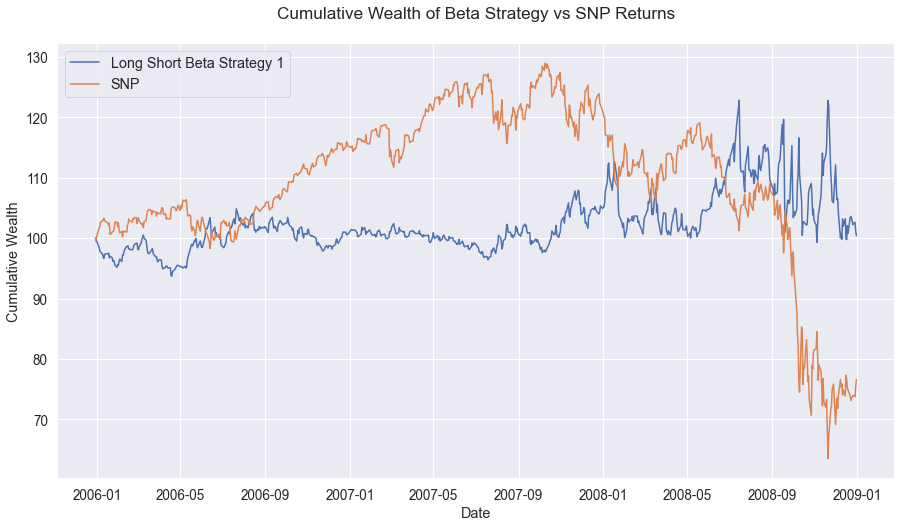

In [14]:
plt.title('Cumulative Wealth of Beta Strategy vs SNP Returns')
plt.plot(portfolio_returns_1['Pointdate'], portfolio_returns_1['Cumulative_Returns'], label = 'Long Short Beta Strategy 1', markersize=3)
plt.plot(snp_returns['Date'], 100 * np.cumprod(1 + snp_returns['Return']), label = 'SNP', markersize=3)
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth')
plt.legend(loc='upper left')
plt.show()

#### The Long Short Beta Strategy protects the Portfolio against maximum drawdown during the Financial Crisis of 2007- 2009 when the SNP 500 exhibits high volatility. 

### Plot of time series Turnover of the Portfolio

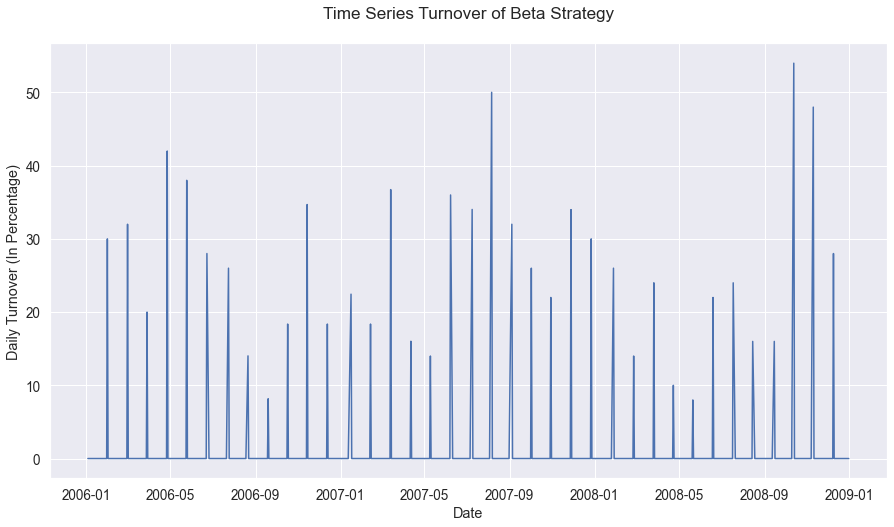

In [15]:
plt.title('Time Series Turnover of Beta Strategy')
plt.plot(portfolio_returns_1['Pointdate'].iloc[1:], daily_turnover)
plt.xlabel('Date')
plt.ylabel('Daily Turnover (In Percentage)')
plt.show()

**Note that Daily Turnover stays 0 for each day during the rebalancing period and spikes up after every rebalancing day due to Portfolio Rebalancing**

### Plot of time series number of stocks in the Portfolio

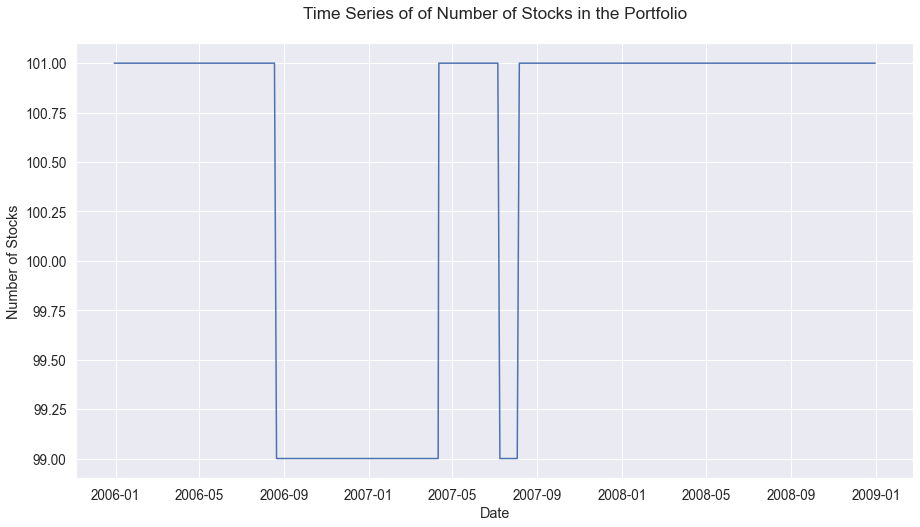

In [16]:
num_stocks = df_weights.iloc[:, 1:].astype(bool).sum(axis=1)
plt.title('Time Series of of Number of Stocks in the Portfolio')
plt.plot(portfolio_returns_1['Pointdate'], num_stocks)
plt.xlabel('Date')
plt.ylabel('Number of Stocks')
plt.show()

**The Number of Stocks oscillates between 99 to 101 due to the fact that some S&P index has a little more than 500 stocks and sometimes a little less than 500 stocks.**

## Bonus Section

### Optimization of Parameters like Rebalancing period, number of stocks to pick for the Portfolio etc.

In [17]:
#Using 45 days of Rebalancing and 7.5 percent of stocks to pick in each of the long and short basket (Obtained this parameter via Experimen)
portfolio_obj = PortfolioConstruction(df_rank_beta, rebalancing_period = 45, pick_percent = 7.5, strategy = "equal_weighted")
df_weights = portfolio_obj.longShortStrategy()

In [18]:
performance_statistics = PortfolioStatistics(df_weights, df_pivot_returns)
#Compute various Statistics of the Portfolio
portfolio_returns_2 = performance_statistics.portfolioReturns()
num_stocks = performance_statistics.numberOfStocks()
annualized_returns = performance_statistics.annualizedReturns()
annualized_volatility = performance_statistics.annualizedVolatility()
sharpe = performance_statistics.annualizedSharpe()
daily_turnover, total_turnover = performance_statistics.turnover()
max_drawdowns = performance_statistics.maxDrawdown(portfolio_returns_2['Cumulative_Returns'])

#Compare it with S&P 500 Benchmark Statistics
snp_returns = snp_returns.loc[snp_returns['Date'] >= "2005-12-30"]
snp_returns.reset_index(drop=True, inplace=True)
snp_max_drawdowns = performance_statistics.maxDrawdown(np.cumprod(1 + snp_returns['Return']))

performance_statistics.printPortfolioStatistics(annualized_returns, annualized_volatility, sharpe, total_turnover, max_drawdowns, snp_max_drawdowns)

The Performance Statistics of the Portfolio are as follows:

Annualized Returns: 4.457%
Annualized Volatility:  0.223
Sharpe:  -0.075
Total Turnover: 1.018%
Maximum Drawdowns: 21.002%
S&P Maximum Drawdowns (Benchmark): 50.76%


**With 45 days Rebalancing period and picking around 7.5% of stocks in each long and short basket, we get an improvement in the Annualized Return, Sharpe, and Total Turnover.** 

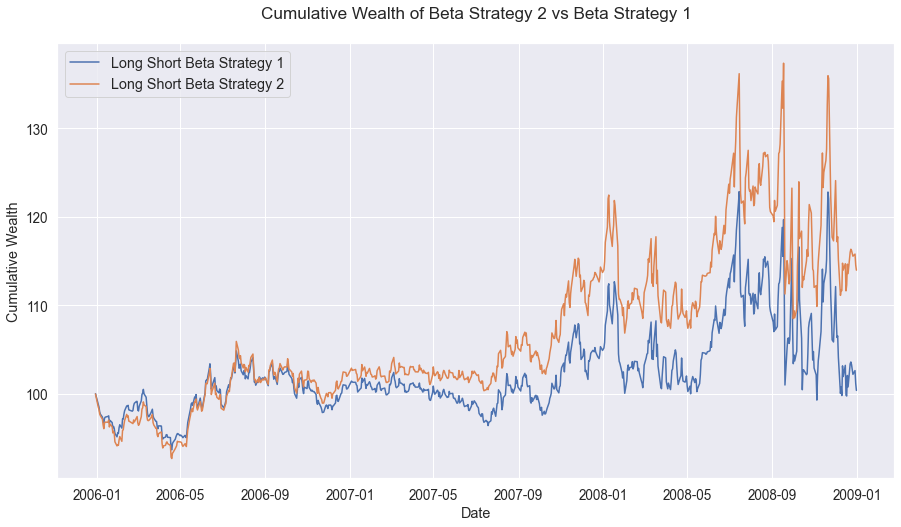

In [19]:
plt.title('Cumulative Wealth of Beta Strategy 2 vs Beta Strategy 1')
plt.plot(portfolio_returns_1['Pointdate'], portfolio_returns_1['Cumulative_Returns'], label = 'Long Short Beta Strategy 1', markersize=3)
plt.plot(portfolio_returns_2['Pointdate'], portfolio_returns_2['Cumulative_Returns'], label = 'Long Short Beta Strategy 2', markersize=3)
#plt.plot(snp_returns['Date'], 100 * np.cumprod(1 + snp_returns['Return']), label = 'SNP', markersize=3)
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth')
plt.legend(loc='upper left')
plt.show()

**Also we can conclude the Cumulative Wealth Curve of the Beta Strategy 2 beats the Cumulative Wealth Curve of the Beta Strategy 1 in the long run with the help of Parameter Optimization**